In [45]:
#!pip install rectools hnswlib optuna annoy > None

In [99]:
import os

import pandas as pd
import numpy as np
from scipy import sparse

import requests
from tqdm.auto import tqdm

from rectools.metrics import MAP
from rectools import Columns
from lightfm import LightFM

import implicit
from implicit.als import AlternatingLeastSquares

import optuna
import hnswlib
from annoy import AnnoyIndex

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
SEED = 2022
K_RECOS = 10

## Get data

In [49]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


In [50]:
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [51]:
#!unzip kion.zip

In [52]:
def load_data():
  interactions = pd.read_csv('kion_train/interactions.csv')
  users = pd.read_csv('kion_train/users.csv')
  items = pd.read_csv('kion_train/items.csv')
  interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'total_dur': 'weight',
    },
    inplace=True,
  )

  interactions['datetime'] = pd.to_datetime(interactions['datetime'])
  interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
  return interactions, users, items

In [53]:
interactions, users, items = load_data()
last_date = interactions['datetime'].max().normalize()

train = interactions[interactions[Columns.Datetime] < last_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= last_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 5)
test: (490982, 5)


In [54]:
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [55]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

In [56]:
TEST_USERS = test[Columns.User].unique()

## Models

In [57]:
def calc_map(reco):
    global test, TEST_USERS, K_RECOS
    if type(reco) != pd.core.frame.DataFrame:
      reco_df = pd.DataFrame(
          {
              Columns.User: np.repeat(TEST_USERS, K_RECOS),
              Columns.Item: np.array(reco).ravel(),
              Columns.Rank: np.tile(np.arange(K_RECOS) + 1, len(TEST_USERS)),
          }
      )
      metric = MAP(k=K_RECOS).calc(reco_df, test)
    else:
      metric = MAP(k=K_RECOS).calc(reco, test)
    return metric

### ALS

In [58]:
ui_csr = sparse.csr_matrix(
    (
        np.ones(len(train), dtype=np.float32),
        (
            train["user_id"].values,
            train["item_id"].values,
        ),
    ),
)

In [59]:
iu_csr = ui_csr.T.tocsr(copy=False)  # В версии implicit==0.4.4 матрицу нужно транспонировать

In [60]:
%%time
model = AlternatingLeastSquares(factors=32, iterations=10, num_threads=12)  # Если есть GPU, можно на нем
model.fit(iu_csr, show_progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 5.28 s, sys: 27.9 ms, total: 5.3 s
Wall time: 5.32 s


### ANN

In [61]:
users_factors = model.user_factors
items_factors = model.item_factors

In [62]:
%%time
ann_index = hnswlib.Index(space="ip", dim=model.factors)
ann_index.init_index(max_elements=items_factors.shape[0])

CPU times: user 5 µs, sys: 982 µs, total: 987 µs
Wall time: 1.13 ms


In [63]:
%%time
ann_index.add_items(items_factors)

CPU times: user 2.29 s, sys: 48.6 ms, total: 2.34 s
Wall time: 1.31 s


In [64]:
%%time
test_user_factors = users_factors[TEST_USERS]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS)

CPU times: user 1.26 s, sys: 7.83 ms, total: 1.27 s
Wall time: 678 ms


In [65]:
calc_map(reco_ann)

0.011743994907832336

#### Filter viewed

In [66]:
%%time
test_user_factors = users_factors[TEST_USERS]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)

CPU times: user 5.65 s, sys: 30 ms, total: 5.68 s
Wall time: 3.05 s


In [117]:
def filter_viewed(recos):
  if type(recos) != list:
    recos = map(lambda x: x.tolist(), recos)

  test_recs = pd.DataFrame(TEST_USERS.reshape(-1, 1), columns=['user_id'])
  test_recs['item_id'] = pd.Series(recos)
  test_recs = test_recs.explode('item_id')

  viewed_items = train[train['user_id'].isin(TEST_USERS)]
  viewed_recs = test_recs.merge(viewed_items[['user_id', 'item_id']], on=['user_id', 'item_id'], how='left', indicator=True)
  new_recs = viewed_recs[viewed_recs['_merge'] != 'both']

  new_recs['rank'] = new_recs.groupby('user_id').cumcount() + 1
  new_recs = new_recs[new_recs['rank'] < 11]
  new_recs = new_recs.drop('_merge', axis=1)
  return new_recs

In [68]:
new_recs = filter_viewed(reco_ann)
new_recs.shape

(1205190, 3)

In [69]:
assert new_recs.groupby('user_id').count().min()['rank'] == 10

In [70]:
calc_map(new_recs)

0.022229548179557697

Metric is better than previous

#### Tuning ANN index params

In [119]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Params: ")
  for key, value in study.best_trial.params.items():
      print("    {}: {}".format(key, value))

In [120]:
def objective_ANNModel(trial):
    M = trial.suggest_int("M", low=16, high=96, step=8)
    ef_construction = trial.suggest_int("ef_construction", low=180, high=280, step=20)

    ann_index = hnswlib.Index(space="ip", dim=model.factors)
    ann_index.init_index(max_elements=items_factors.shape[0], M=M, ef_construction=ef_construction)
    ann_index.add_items(items_factors)
    test_user_factors = users_factors[TEST_USERS]
    reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)

    new_recs = filter_viewed(reco_ann)
    metric = calc_map(new_recs)

    return metric

In [121]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective_ANNModel, n_trials=30)

[I 2022-12-06 18:56:12,429] A new study created in memory with name: no-name-940ea188-51fc-4ae0-85b0-854f6bccd7a0
[I 2022-12-06 18:56:38,175] Trial 0 finished with value: 0.022585125829178734 and parameters: {'M': 96, 'ef_construction': 200}. Best is trial 0 with value: 0.022585125829178734.
[I 2022-12-06 18:57:00,121] Trial 1 finished with value: 0.02250923901441686 and parameters: {'M': 64, 'ef_construction': 200}. Best is trial 0 with value: 0.022585125829178734.
[I 2022-12-06 18:57:29,349] Trial 2 finished with value: 0.02258581877283088 and parameters: {'M': 96, 'ef_construction': 220}. Best is trial 2 with value: 0.02258581877283088.
[I 2022-12-06 18:57:58,304] Trial 3 finished with value: 0.022520121712817413 and parameters: {'M': 80, 'ef_construction': 260}. Best is trial 2 with value: 0.02258581877283088.
[I 2022-12-06 18:58:20,502] Trial 4 finished with value: 0.022486805430913376 and parameters: {'M': 56, 'ef_construction': 220}. Best is trial 2 with value: 0.022585818772830

CPU times: user 16min 55s, sys: 13.3 s, total: 17min 8s
Wall time: 11min 40s


In [123]:
print_study_info(study)

Number of finished trials:  30
Params: 
    M: 96
    ef_construction: 240


In [131]:
study.best_value

0.022593151193141595

#### annoy

In [71]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [72]:
users_factors.shape, items_factors.shape

((1097558, 32), (16519, 32))

In [75]:
max_norm, augmented_item_factors = augment_inner_product(items_factors)
augmented_item_factors.shape

(16519, 33)

In [74]:
extra_zero = np.zeros((users_factors.shape[0], 1))
augmented_user_factors = np.append(users_factors, extra_zero, axis=1)
augmented_user_factors.shape

(1097558, 33)

In [135]:
def objective_ANN_Annoy_Model(trial):
    n_trees = trial.suggest_int("M", low=60, high=160, step=20)

    index = AnnoyIndex(augmented_item_factors.shape[1], 'dot')
    for i in range(len(augmented_item_factors)):
        index.add_item(i, augmented_item_factors[i])
    index.build(n_trees=n_trees)

    nbrs = [t.get_nns_by_vector(query_matrix[i], 60) for i in range(len(query_matrix))]

    new_recs = filter_viewed(reco_ann)
    metric = calc_map(new_recs)

    return metric

In [107]:
query_matrix = augmented_user_factors[TEST_USERS]

In [136]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective_ANN_Annoy_Model, n_trials=10)

[I 2022-12-06 19:16:00,932] A new study created in memory with name: no-name-ed3394ff-f2eb-41b3-a2d3-9c5ff30a1c8e
[I 2022-12-06 19:17:30,615] Trial 0 finished with value: 0.022229548179557697 and parameters: {'M': 160}. Best is trial 0 with value: 0.022229548179557697.
[I 2022-12-06 19:18:57,630] Trial 1 finished with value: 0.022229548179557697 and parameters: {'M': 100}. Best is trial 0 with value: 0.022229548179557697.
[I 2022-12-06 19:20:22,629] Trial 2 finished with value: 0.022229548179557697 and parameters: {'M': 60}. Best is trial 0 with value: 0.022229548179557697.
[I 2022-12-06 19:21:51,665] Trial 3 finished with value: 0.022229548179557697 and parameters: {'M': 160}. Best is trial 0 with value: 0.022229548179557697.
[I 2022-12-06 19:23:17,503] Trial 4 finished with value: 0.022229548179557697 and parameters: {'M': 80}. Best is trial 0 with value: 0.022229548179557697.
[I 2022-12-06 19:24:44,861] Trial 5 finished with value: 0.022229548179557697 and parameters: {'M': 120}. Be

CPU times: user 14min 59s, sys: 5.67 s, total: 15min 5s
Wall time: 14min 36s


In [137]:
print_study_info(study)

Number of finished trials:  10
Params: 
    M: 160


In [138]:
study.best_value

0.022229548179557697

#### Best model

The best model is hnswlib

In [133]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(interactions.user_id)]
warm = recs[recs['user_id'].isin(interactions.user_id)]

In [154]:
TEST_USERS = warm['user_id'].unique()

In [155]:
ann_index = hnswlib.Index(space="ip", dim=model.factors)
ann_index.init_index(max_elements=items_factors.shape[0], M=96, ef_construction=240)
ann_index.add_items(items_factors)
test_user_factors = users_factors[warm['user_id'].unique()]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)
new_recs = filter_viewed(reco_ann)

### Submit

In [134]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])
cold_recs.head()

,user_id,item_id
0,29,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
1,33,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
2,70,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
3,74,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
4,85,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."


In [157]:
recos = new_recs.drop(['rank'], axis=1).groupby('user_id').agg({'item_id': list}).reset_index()
recos.head()

,user_id,item_id
0,3,"[14431, 7102, 14317, 15464, 10772, 5693, 849, ..."
1,11,"[3076, 11778, 7476, 6192, 3935, 14741, 3784, 4..."
2,30,"[7102, 14431, 10464, 3935, 9169, 657, 3076, 11..."
3,39,"[47, 1163, 1168, 1358, 1554, 3006, 3066, 3190,..."
4,46,"[5658, 16228, 7102, 6402, 14431, 1132, 3784, 1..."


In [158]:
res = pd.concat((cold_recs, recos))
assert res.shape[0] == submission.shape[0]
res.to_csv('ann.csv', index=False)

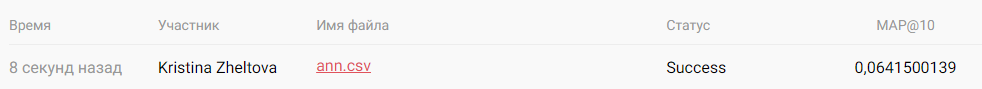